# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, warnings=False, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9784
Test evaluation --> roc_auc: 0.8726
Time elapsed: 0.324s
-------------------------------------------------
Total time: 0.325s


Final results ==================== >>
Duration: 0.325s
-------------------------------------
LightGBM --> roc_auc: 0.8726


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Series([], dtype: int64)

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.14457831325301204 repeated in 100.0% of the rows.
 --> Feature Cloud3pm + WindDir3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + WindGustSpeed was removed due to collinearity with another feature.
 --> Feature Cloud9am - RainToday_other was removed due to collinearity with another feature.
 --> Feature Evaporation - WindGustDir was removed due to collinearity with another feature.
 --> Feature Humidity3pm - Location was removed due to collinearity with another feature.
 --> Feature Humidity3pm - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humidity3pm - WindDir9am was removed due to collinearity with another feature.
 --> Feature Location + Pressure3pm was removed due to collinearity with another feature.
 --> Feature Location + Temp3pm was removed due to collinearity with another feature.
 --> Feat

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + WindDir3pm,Cloud3pm,0.99975
1,Cloud3pm + WindGustSpeed,WindGustSpeed,0.98743
2,Cloud9am - RainToday_other,Cloud9am,0.99957
3,Evaporation - WindGustDir,Evaporation,0.99989
4,Humidity3pm - Location,Humidity3pm,1.0
5,Humidity3pm - WindDir3pm,"Humidity3pm, Humidity3pm - Location","1.0, 1.0"
6,Humidity3pm - WindDir9am,"Humidity3pm, Humidity3pm - Location, Humidity3...","1.0, 1.0, 1.0"
7,Location + Pressure3pm,Pressure3pm,1.0
8,Location + Temp3pm,Temp3pm,1.0
9,Location + WindDir3pm,WindDir3pm,1.0


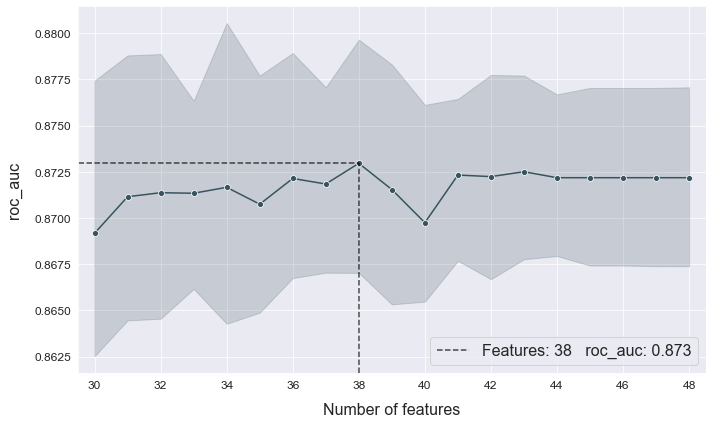

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9947
Test evaluation --> roc_auc: 0.8761
Time elapsed: 0.555s
-------------------------------------------------
Total time: 0.556s


Final results ==================== >>
Duration: 0.557s
-------------------------------------
LightGBM --> roc_auc: 0.8761


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.10         0.134439        3         0.506379              N/A     19.87s
   1     3.26         0.335945        5         0.541149              N/A     20.30s
   2     3.58         0.450601        7         0.545993              N/A     21.59s
   3     5.24         0.478227       10         0.551393              N/A     17.73s
   4     6.52         0.509589       16         0.556724              N/A     16.76s
   5     7.66         0.511601       17         0.558144              N/A     15.35s
   6     8.65         0.496554       15          0.56325              N/A     14.56s
   7    10.22         0.488689       15          0.56325              N/A     13.79s
   8    12.63          0.49883       15        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,feature_24,"mul(sub(sub(Sunshine, WindGustSpeed), Humidity...",0.55025
1,feature_25,"mul(sub(sub(Sunshine, WindGustSpeed), Humidity...",0.55025
2,feature_26,"mul(mul(sub(sub(Sunshine, WindGustSpeed), Humi...",0.55025
3,feature_27,"mul(mul(Humidity3pm, sub(sub(Sunshine, WindGus...",0.55025
4,feature_28,"mul(Humidity3pm, mul(sub(sub(Sunshine, WindGus...",0.55025
5,feature_29,"mul(mul(sub(sub(Sunshine, WindGustSpeed), Humi...",0.55025


In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.98
Test evaluation --> roc_auc: 0.8742
Time elapsed: 0.474s
-------------------------------------------------
Total time: 0.474s


Final results ==================== >>
Duration: 0.475s
-------------------------------------
LightGBM --> roc_auc: 0.8742


## Analyze results

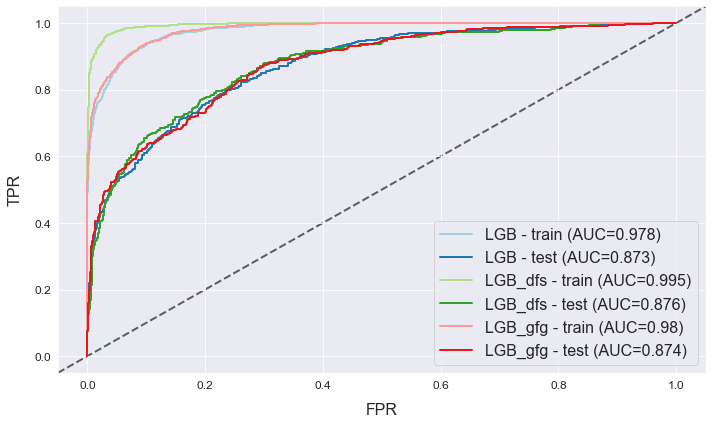

In [17]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

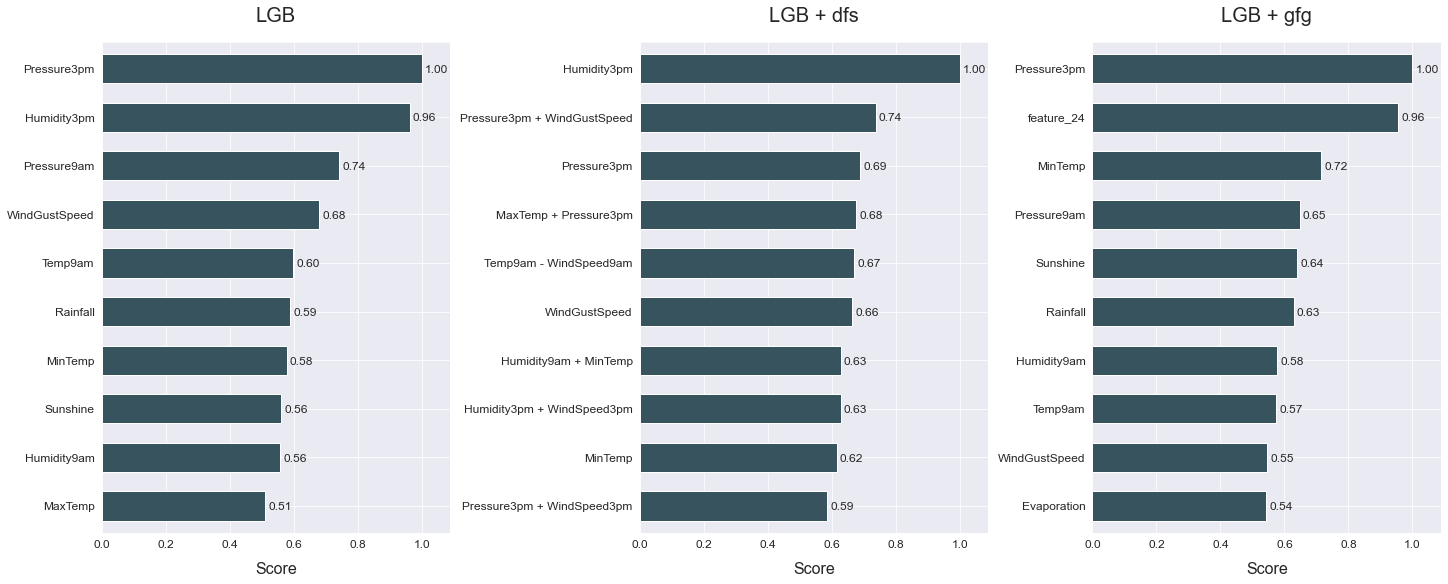

In [18]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + gfg")

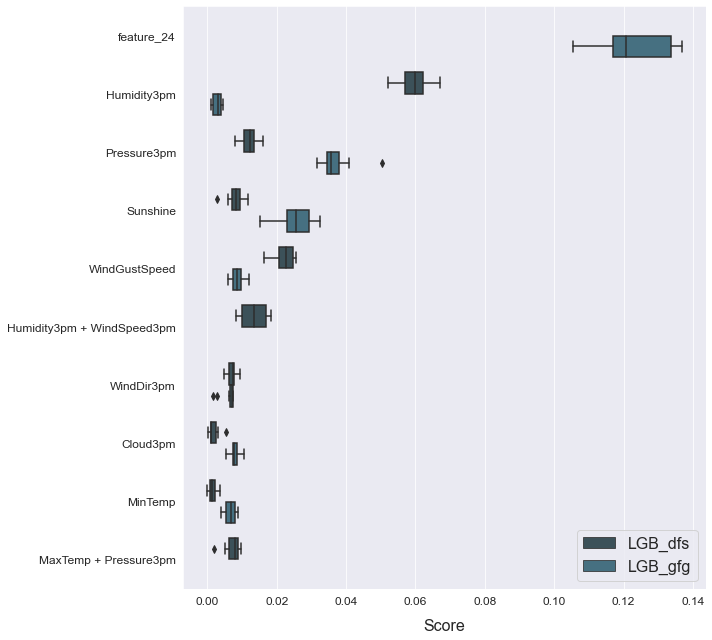

In [19]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=10)

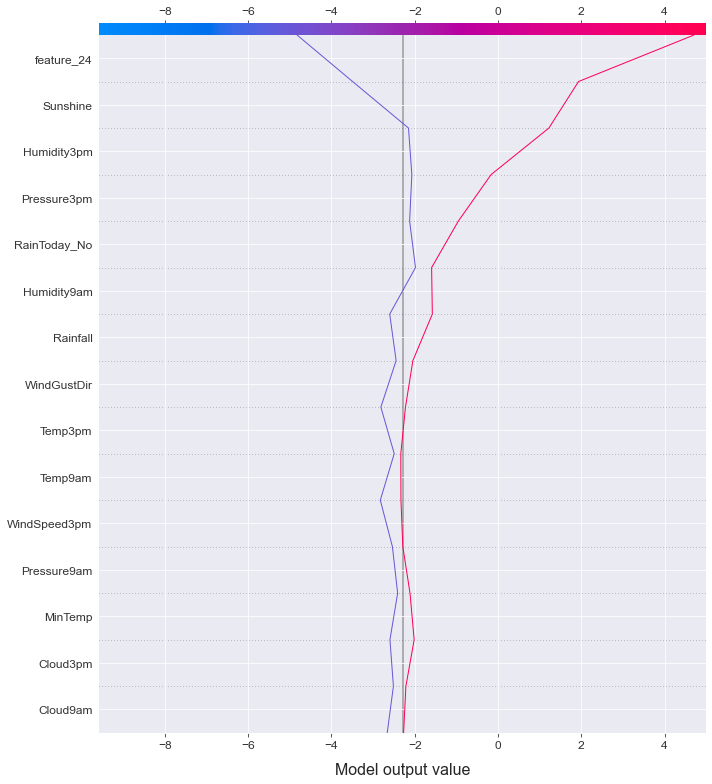

In [20]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)